In [2]:
from solcore import material
from solcore.structure import Layer, Junction, TunnelJunction
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
import solcore.poisson_drift_diffusion as PDD

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
T = 298
wl = np.linspace(350, 1050, 301) * 1e-9

In [5]:
#First, we create the materials of the QW
QWmat = material("InGaAs")(T=T, In=0.2, strained=True)
Bmat = material("GaAsP")(T=T, P=0.1, strained=True)
i_GaAs = material("GaAs")(T=T)

# The QW is 7 nm wide, with GaAs interlayers 2 nm thick at each side and GaAsP barriers
# 10 nm thick. The final device will have 30 of these QWs.
QW = PDD.QWunit(
    [
        Layer(width=10e-9, material=Bmat, role="barrier"),
        Layer(width=2e-9, material=i_GaAs, role="well"),
        Layer(width=7e-9, material=QWmat, role="well"),
        Layer(width=2e-9, material=i_GaAs, role="well"),
        Layer(width=10e-9, material=Bmat, role="barrier"),
    ],
    T=T,
    repeat=30,
    substrate=i_GaAs,
)

In [6]:
# We solve the quantum properties of the QW, leaving the default values of all
# parameters
QW_list = QW.GetEffectiveQW(wavelengths=wl)

Solving QW properties...


In [7]:
# Materials for the BOTTOM junction
window_bottom = material("GaInP")(T=T, Nd=5e24, In=0.49)
n_GaAs = material("GaAs")(T=T, Nd=1e24)
p_GaAs = material("GaAs")(T=T, Na=8e22)
bsf_bottom = material("GaInP")(T=T, Na=5e24, In=0.49)

# If you want to test the code without QWs, to make ti a bit faster, comment the line
# with QW_list
GaAs_junction = Junction(
    [
        Layer(width=10e-9, material=window_bottom, role="Window"),
        Layer(width=150e-9, material=n_GaAs, role="Emitter"),
    ]
    # Comment the following line to remove the QWs
    + QW_list
    + [
        Layer(width=2000e-9, material=p_GaAs, role="Base"),
        Layer(width=200e-9, material=bsf_bottom, role="BSF"),
    ],
    sn=1e6,
    sp=1e6,
    T=T,
    kind="PDD",
)

In [8]:
# Materials for the TOP junction
window_top = material("AlInP")(
    T=T, Nd=5e23, Al=0.53, electron_mobility=0.01, hole_mobility=7e-4
)
n_GaInP = material("GaInP")(T=T, Nd=5e23, In=0.49)
p_GaInP = material("GaInP")(T=T, Na=8e22, In=0.49)
bsf_top = material("AlInP")(
    T=T, Na=5e23, Al=0.53, electron_mobility=0.01, hole_mobility=7e-4
)

# We create the Top junction, leaving outside the window and bsf layers. They work
# well in the dark, but cause convergence issues under illumination.
GaInP_junction = Junction(
    [
        Layer(width=120e-9, material=n_GaInP, role="Emitter"),
        Layer(width=800e-9, material=p_GaInP, role="Base"),
    ],
    sn=1e3,
    sp=1e3,
    T=T,
    kind="PDD",
)

In [9]:
# We create the tunnel junction
tunnel = TunnelJunction(
    [Layer(width=40e-9, material=n_GaInP, role="TJ")],
    v_peak=0.2,
    j_peak=7.5e4,
    v_valley=1,
    j_valley=4e4,
    prefactor=5,
    j01=1e-23,
    kind="parametric",
    pn=True,
)

In [10]:
# And the materials needed for the anti reflecting coating
MgF2 = material("MgF2")()
ZnS = material("ZnScub")()

In [11]:
# Finally, we put everithing together to make a solar cell
my_solar_cell = SolarCell(
    [
        Layer(width=110e-9, material=MgF2, role="ARC1"),
        Layer(width=60e-9, material=ZnS, role="ARC2"),
        Layer(width=30e-9, material=window_top, role="window"),
        GaInP_junction,
        Layer(width=100e-9, material=bsf_top, role="BSF"),
        tunnel,
        GaAs_junction,
    ],
    T=T,
    substrate=n_GaAs,
)

In [12]:
light_source = LightSource(
    source_type="standard",
    version="AM1.5g",
    x=wl,
    output_units="photon_flux_per_m",
    concentration=1,
)

In [13]:
# The definitions are all done, so we just start solving the properties,
# starting with the QE. We calculate the QE curve under illumination
solar_cell_solver(
    my_solar_cell,
    "qe",
    user_options={
        "light_source": light_source,
        "wavelength": wl,
        "optics_method": "TMM",
    },
)

Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...
...done!

 CREATE MESH...
 Masternodes at (nm):
...done!

       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    5.99632872E-29
 Elapsed time =    7.81250000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.1085E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.6178E-26    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.5348E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

In [14]:
# And now, the IV curves under various concentration levels.
# NOTE: Due to the presence of QWs and the fact we calculate things a 19 different
# concentrations, this might take a while (~4 hours).
# Remove the QWs as indicated above to test the code much faster.
num_con = 19
con = np.logspace(0, 3, num_con)
vint = np.linspace(-3.5, 4, 600)
V = np.linspace(-3.5, 0, 300)
allI = []
isc = []
voc = []
FF = []
pmpp = []

Solving IV of the junctions...
Solving IV...
Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =   0.109375000     s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E-14    0.6130E-18    0.

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2913E-19    0.2361E-26    0.2917E-19         2
         2   -0.2255E-17    0.4124E-18    0.2914E-18    0.1351E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2917E-17    0.1169E-24    0.2920E-17         2
         4   -0.2117E-15    0.5489E-17    0.4581E-17    0.7067E-23    0.3024E-17         2
         5   -0.2114E-14    0.2

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
...done!

 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2913E-19    0.2361E-26    0.2917E-19         2
         2   -0.2255E-17    0.4124E-18    0.2914E-18    0.1351E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2917E-17    0.1169E-24    0.2920E-17         2
         4   -0.2117E-15    0.5489E-17    0.4581E-17    0.7067E-23    0.3024E-17         2
         5   -0.2114E-14    0.2985E-16    0.2312E-16  

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
     398.0
     4

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2361E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4281E-18    0.1351E-25    0.4285E-18         2
         3   -0.3309E-16    0.6061E-17    0.4284E-17    0.1168E-24    0.4287E-17         2
         4   -0.3097E-15    0.2989E-16    0.2428E-16    0.4195E-22    0.1744E-16         2
         5   -0.3110E-14    0.3

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2361E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4281E-18    0.1351E-25    0.4285E-18         2
         3   -0.3309E-16    0.6061E-17    0.4284E-17    0.1168E-24    0.4287E-17         2
         4   -0.3097E-15    0.2989E-16    0.2428E-16    0.4195E-22    0.1744E-16         2
         5   -0.3110E-14    0.3125E-18    0.2935E-18    0.3539E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8895E-19    0.6288E-19    0.2361E-26    0.6291E-19         2
         2   -0.4858E-17    0.8896E-18    0.6288E-18    0.1350E-25    0.6293E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1168E-24    0.6295E-17         2
         4   -0.4565E-15    0.1994E-17    0.1891E-17    0.2083E-23    0.6323E-18         2
         5   -0.4565E-14    0.2238E-17    0.1738E-17    0.1238E-

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8895E-19    0.6288E-19    0.2361E-26    0.6291E-19         2
         2   -0.4858E-17    0.8896E-18    0.6288E-18    0.1350E-25    0.6293E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1168E-24    0.6295E-17         2
         4   -0.4565E-15    0.1994E-17    0.1891E-17    0.2083E-23    0.6323E-18         2
         5   -0.4565E-14    0.2238E-17    0.1738E-17    0.1238E-22    0.1411E-17         2
         6   -0.4565E-13    0.2013E-16    0.1

Processing structure...
...done!

Solving equilibrium...
...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1297E-19    0.9147E-20    0.2361E-26    0.9189E-20         2
         2   -0.7125E-18    0.1297E-18    0.9155E-19    0.1347E-25    0.9191E-19         2
         3   -0.7125E-17    0.1301E-17    0.9183E-18    0.1171E-24    0.9210E-18         2
         4   -0.7128E-16    0.1303E-16    0.9197E-17    0.8705E-24    0.9226E-17         2
         5   -0.6701E-15    0.8326E-18    0.7725E-18  

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
...done!

      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1297E-19    0.9147E-20    0.2361E-26    0.9189E-20         2
         2   -0.7125E-18    0.1297E-18    0.9155E-19    0.1347E-25    0.9191E-19         2
         3   -0.7125E-17    0.1301E-17    0.9183E-18    0.1171E-24    0.9210E-18         2
         4   -0.7128E-16    0.1303E-16    0.9197E-17    0.8705E-24    0.9226E-17         2
         5   -0.6701E-15    0.8326E-18    0.7725E-18    0.6427E-24    0.3105E-18         2
         6   -0.6700E-14    0.3215E-17    0.2

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1908E-19    0.1347E-19    0.2361E-26    0.1351E-19         2
         2   -0.1046E-17    0.1909E-18    0.1348E-18    0.1348E-25    0.1352E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1170E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.8706E-24    0.1355E-16         2
         5   -0.9835E-15    0.3137E-17    0.2887E-17  

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1908E-19    0.1347E-19    0.2361E-26    0.1351E-19         2
         2   -0.1046E-17    0.1909E-18    0.1348E-18    0.1348E-25    0.1352E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1170E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.8706E-24    0.1355E-16         2
         5   -0.9835E-15    0.3137E-17    0.2887E-17    0.2136E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =   0.109375000     s
  
  
 Starting LIGHTSC... 
...done!

      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E-14    0.6130E-18    0.5651E-18    0.2791E-24    0.2374E-18         2
         6   -0.1444E-13    0.6400E

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
...done!

     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
...done!

Solving equilibrium...
...done!

     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
...done!

     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
...done!

 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2913E-19    0.2361E-26    0.2917E-19         2
         2   -0.2255E-17    0.4124E-18    0.2914E-18    0.1351E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2917E-17    0.1169E-24    0.2920E-17         2
         4   -0.2117E-15    0.5489E-17    0.4581E-17    0.7067E-23    0.3024E-17         2
         5   -0.2114E

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2913E-19    0.2361E-26    0.2917E-19         2
         2   -0.2255E-17    0.4124E-18    0.2914E-18    0.1351E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2917E-17    0.1169E-24    0.2920E-17         2
         4   -0.2117E-15    0.5489E-17    0.4581E-17    0.7067E-23    0.3024E-17         2
         5   -0.2114E-14    0.2985E-16    0.2312E-16    0.1686E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

...done!

Solving equilibrium...
...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    7.81250000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2361E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4281E-18    0.1351E-25    0.4285E-18         2
         3   -0.3309E-16    0.6061E-17    0.4284E-17    0.1168E-24    0.4287E-17         2
         4   -0.3097E-15    0.2989E-16    0.2428E-16    0.4195E-22    0.1744E-16         2
         5   -0.3110E-14    0.3

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =   0.109375000     s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2361E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4281E-18    0.1351E-25    0.4285E-18         2
         3   -0.3309E-16    0.6061E-17    0.4284E-17    0.1168E-24    0.4287E-17         2
         4   -0.3097E-15    0.2989E-16    0.2428E-16    0.4195E-22    0.1744E-16         2
         5   -0.3110E-14    0.3125E-18    0.2935E-18    0.3539E-24    0.1074E-18         2
         6   -0.3110E-13    0.1357E-16    0.85

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!

 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8895E-19    0.6288E-19    0.2361E-26    0.6291E-19         2
         2   -0.4858E-17    0.8896E-18    0.6288E-18    0.1350E-25    0.6293E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1168E-24    0.6295E-17         2
         4   -0.4565E-15    0.1994E-17    0.1891E-17    0.2083E-23    0.6323E-18         2
         5   -0.4565E-14    0.2238E-17    0.1738E-17    0.1238E-22    0.1411E-17         2
         6   -0.4565E-13    0.2013E-16    0.1257E-16   

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =   0.109375000     s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8895E-19    0.6288E-19    0.2361E-26    0.6291E-19         2
         2   -0.4858E-17    0.8896E-18    0.6288E-18    0.1350E-25    0.6293E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1168E-24    0.6295E-17         2
         4   -0.4565E-15    0.1994E-17    0.1891E-17    0.2083E-23    0.6323E-18         2
         5   -0.4565E-14    0.2238E-17    0.1738E-17    0.1238E-22    0.1411E-17         2
         6   -0.4565E-13    0.2013E-16    0.12

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
...done!

Solving equilibrium...
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
...done!
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
...done!

      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1297E-19    0.9147E-20    0.2361E-26    0.9189E-20         2
         2   -0.7125E-18    0.1297E-18    0.9155E-19    0.1347E-25    0.9191E-19         2
         3   -0.7125E-17    0.1301E-17    0.9183E-18    0.1171E-24    0.9210E-18         2
         4   -0.7128E-16    0.1303E-16    0.9197E-17    0.8705E-24    0.9226E-17         2
         5   -0.6701E-15    0.8326E-18    0.7725E-18    0.6427E-24    0.3105E-18         2
         6   -0.6700E-14    0.3215E-17    0.2

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1297E-19    0.9147E-20    0.2361E-26    0.9189E-20         2
         2   -0.7125E-18    0.1297E-18    0.9155E-19    0.1347E-25    0.9191E-19         2
         3   -0.7125E-17    0.1301E-17    0.9183E-18    0.1171E-24    0.9210E-18         2
         4   -0.7128E-16    0.1303E-16    0.9197E-17    0.8705E-24    0.9226E-17         2
         5   -0.6701E-15    0.8326E-18    0.7725E-18    0.6427E-24    0.3105E-18         2
         6   -0.6700E-14    0.3215E-17    0.2294E-17   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1908E-19    0.1347E-19    0.2361E-26    0.1351E-19         2
         2   -0.1046E-17    0.1909E-18    0.1348E-18    0.1348E-25    0.1352E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1170E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.8706E-24    0.1355E-16        

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    4.68750000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1908E-19    0.1347E-19    0.2361E-26    0.1351E-19         2
         2   -0.1046E-17    0.1909E-18    0.1348E-18    0.1348E-25    0.1352E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1170E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.8706E-24    0.1355E-16        

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

Solving equilibrium...
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

...done!

Solving equilibrium...
...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    7.81250000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E

 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E-14    0.6130E-18    0.5651E-18  

Processing structure...
...done!

Solving equilibrium...
...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2913E-19    0.2361E-26    0.2917E-19         2
         2   -0.2255E-17    0.4124E-18    0.2914E-18    0.1351E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2917E-17    0.1169E-24    0.2920E-17         2
         4   -0.2117E-15    0.5489E-17    0.4581E-17    0.7067E-23    0.3024E-17         2
         5   -0.2114E-14    0.2985E-16    0.2312E-16    0.1686E-21    0.1888E-16         2
         6   -0.2119E-13    0.9096E-17    0.6610E-17   

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2254E-18    0.4122E-19    0.2913E-19    0.2361E-26    0.2917E-19         2
         2   -0.2255E-17    0.4124E-18    0.2914E-18    0.1351E-25    0.2918E-18         2
         3   -0.2254E-16    0.4127E-17    0.2917E-17    0.1169E-24    0.2920E-17         2
         4   -0.2117E-15    0.5489E-17    0.4581E-17    0.7067E-23    0.3024E-17         2
         5   -0.2114E-14    0.2985E-16    0.

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2361E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4281E-18    0.1351E-25    0.4285E-18         2
         3   -0.3309E-16    0.6061E-17    0.4284E-17    0.1168E-24    0.4287E-17         2
         4   -0.3097E-15    0.2989E-16    0.2428E-16    0.4195E-22    0.1744E-16         2
         5   -0.3110E-14    0.3

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
...done!

 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.3309E-18    0.6056E-19    0.4280E-19    0.2361E-26    0.4284E-19         2
         2   -0.3309E-17    0.6057E-18    0.4281E-18    0.1351E-25    0.4285E-18         2
         3   -0.3309E-16    0.6061E-17    0.4284E-17    0.1168E-24    0.4287E-17         2
         4   -0.3097E-15    0.2989E-16    0.2428E-16    0.4195E-22    0.1744E-16         2
         5   -0.3110E-14    0.3125E-18    0.2935E-18  

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
...done!

     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8895E-19    0.6288E-19    0.2361E-26    0.6291E-19         2
         2   -0.4858E-17    0.8896E-18    0.6288E-18    0.1350E-25    0.6293E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1168E-24    0.6295E-17         2
         4   -0.4565E-15    0.1994E-17    0.1891E-17    0.2083E-23    0.6323E-18         2
         5   -0.4565E-14    0.2238E-17    0.1738E-17    0.1238E-

 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.4857E-18    0.8895E-19    0.6288E-19    0.2361E-26    0.6291E-19         2
         2   -0.4858E-17    0.8896E-18    0.6288E-18    0.1350E-25    0.6293E-18         2
         3   -0.4858E-16    0.8899E-17    0.6291E-17    0.1168E-24    0.6295E-17         2
         4   -0.4565E-15    0.1994E-17    0.1891E-17    0.2083E-23    0.6323E-18         2
         5   -0.4565E-14    0.2238E-17    0.1738E-17   

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
     397.9
   

...done!

Solving equilibrium...
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1297E-19    0.9147E-20    0.2361E-26    0.9189E-20         2
         2   -0.7125E-18    0.1297E-18    0.9155E-19    0.1347E-25    0.9191E-19         2
         3   -0.7125E-17    0.1301E-17    0.9183E-18    0.1171E-24    0.9210E-18         2
         4   -0.7128E-16    0.1303E-16    0.9197E-17    0.8705E-24    0.9226E-17         2
         5   -0.6701E-15    0.8326E-18    0.7725E-18    0.6427E-24    0.3105E-18         2
         6  

 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.7118E-19    0.1297E-19    0.9147E-20    0.2361E-26    0.9189E-20         2
         2   -0.7125E-18    0.1297E-18    0.9155E-19    0.1347E-25    0.9191E-19         2
         3   -0.7125E-17    0.1301E-17    0.9183E-18    0.1171E-24    0.9210E-18         2
         4   -0.7128E-16    0.1303E-16    0.9197E-17    0.8705E-24    0.9226E-17         2
         5   -0.6701E-15    0.8326E-18    0.

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
...done!

     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!

 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1908E-19    0.1347E-19    0.2361E-26    0.1351E-19         2
         2   -0.1046E-17    0.1909E-18    0.1348E-18    0.1348E-25    0.1352E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1170E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.8706E-24    0.1355E-16         2
         5   -0.9835E

 CREATE MESH...
...done!

 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
...done!

  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1045E-18    0.1908E-19    0.1347E-19    0.2361E-26    0.1351E-19         2
         2   -0.1046E-17    0.1909E-18    0.1348E-18    0.1348E-25    0.1352E-18         2
         3   -0.1046E-16    0.1912E-17    0.1350E-17    0.1170E-24    0.1353E-17         2
         4   -0.1046E-15    0.1914E-16    0.1352E-16    0.8706E-24    0.1355E-16         2
         5   -0.9835E-15    0.3137E-17    0.2887E-17  

Processing structure...
...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
...done!

       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
...done!

Solving equilibrium...
...done!

 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

...done!

Solving equilibrium...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E-14    0.6

 CREATE MESH...
 Masternodes at (nm):
       0.0
     119.9
     120.0
     920.0
...done!

  
 Initial number of nodes (M+1):          140
 Refining mesh... 
 ... Finished!
 Mesh with           73  nodes.
 ----------------------------------
  
 Starting EQUILIBRIUM... 
 Remeshing...  M+1 =          114  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    1.31495672E-28
 Elapsed time =    9.37500000E-02 s
  
  
 Starting LIGHTSC... 
      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.1535E-18    0.2805E-19    0.1981E-19    0.2361E-26    0.1985E-19         2
         2   -0.1536E-17    0.2806E-18    0.1982E-18    0.1350E-25    0.1986E-18         2
         3   -0.1536E-16    0.2810E-17    0.1985E-17    0.1169E-24    0.1988E-17         2
         4   -0.1536E-15    0.2812E-16    0.1987E-16    0.8707E-24    0.1990E-16         2
         5   -0.1444E-14    0.6130E-18    0.5651E-18    0.2791E-

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
       9.9
      10.0
     159.9
     160.0
     169.9
...done!

Solving equilibrium...
...done!

     170.0
     171.9
     172.0
     178.9
     179.0
     180.9
     181.0
     190.9
     191.0
     200.9
     201.0
     202.9
     203.0
     209.9
     210.0
     211.9
     212.0
     221.9
     222.0
     231.9
     232.0
     233.9
     234.0
     240.9
     241.0
     242.9
     243.0
     252.9
     253.0
     262.9
     263.0
     264.9
     265.0
     271.9
     272.0
     273.9
     274.0
     283.9
     284.0
     293.9
     294.0
     295.9
     296.0
     302.9
     303.0
     304.9
     305.0
     314.9
     315.0
     324.9
     325.0
     326.9
     327.0
     333.9
     334.0
     335.9
     336.0
     345.9
     346.0
     355.9
     356.0
     357.9
     358.0
     364.9
     365.0
     366.9
     367.0
     376.9
     377.0
     386.9
     387.0
     388.9
     389.0
     395.9
     396.0
    

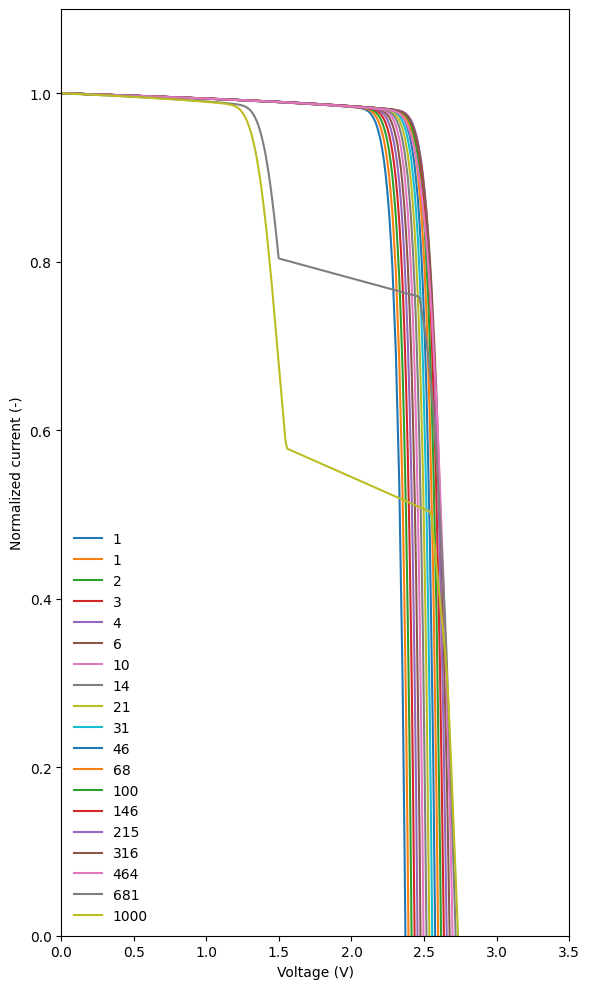

In [15]:
fig3, axIV = plt.subplots(1, 1, figsize=(6, 10))
for c in con:
    light_source.concentration = c
    solar_cell_solver(
        my_solar_cell,
        "iv",
        user_options={
            "light_source": light_source,
            "wavelength": wl,
            "optics_method": None,
            "light_iv": True,
            "mpp": True,
            "voltages": V,
            "internal_voltages": vint,
        },
    )
    isc.append(my_solar_cell.iv["Isc"])
    voc.append(my_solar_cell.iv["Voc"])
    FF.append(my_solar_cell.iv["FF"])
    pmpp.append(my_solar_cell.iv["Pmpp"])
    allI.append(my_solar_cell.iv["IV"][1])

    # And now, everything is plotting...
    axIV.plot(-V, my_solar_cell.iv["IV"][1] / isc[-1], label=int(c))

axIV.legend(loc="lower left", frameon=False)
axIV.set_ylim(0, 1.1)
axIV.set_xlim(0, 3.5)
axIV.set_xlabel("Voltage (V)")
axIV.set_ylabel("Normalized current (-)")
# axIV.spines['top'].set_visible(False)
# axIV.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

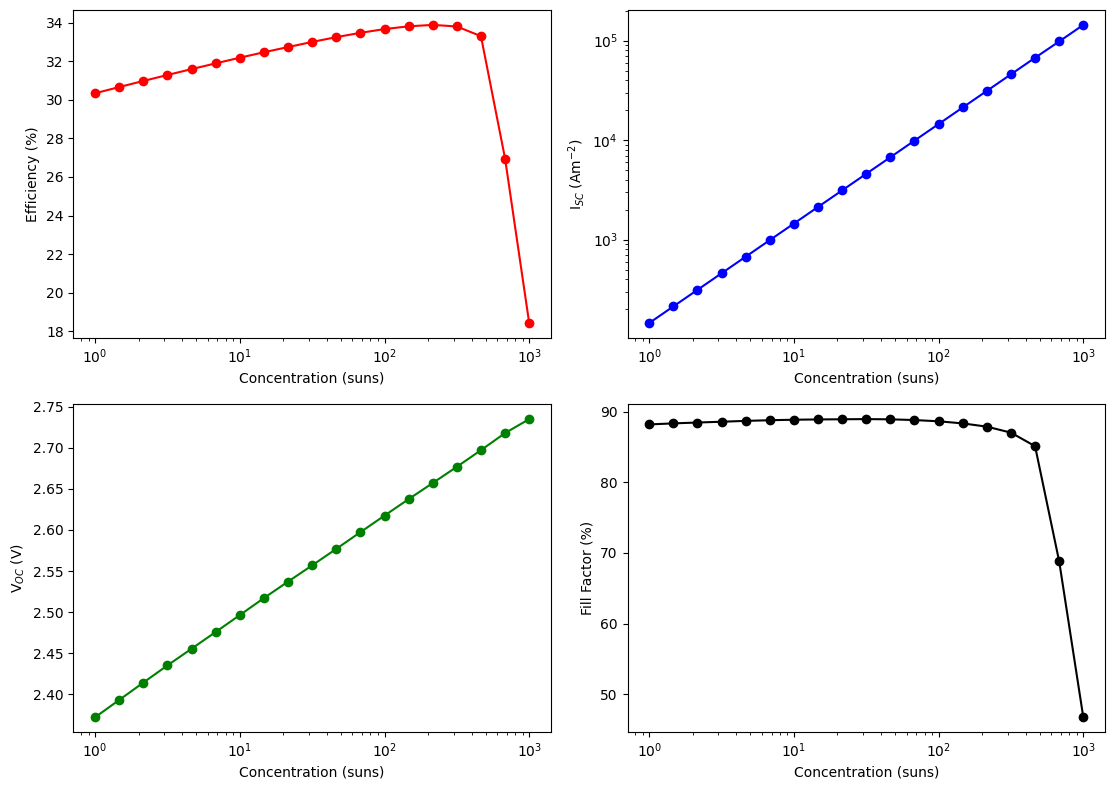

In [16]:
fig2, axes = plt.subplots(2, 2, figsize=(11.25, 8))

axes[0, 0].semilogx(con, np.array(pmpp) / con / 10, "r-o")
axes[0, 0].set_xlabel("Concentration (suns)")
axes[0, 0].set_ylabel("Efficiency (%)")

axes[0, 1].loglog(con, abs(np.array(isc)), "b-o")
axes[0, 1].set_xlabel("Concentration (suns)")
axes[0, 1].set_ylabel("I$_{SC}$ (Am$^{-2}$)")

axes[1, 0].semilogx(con, abs(np.array(voc)), "g-o")
axes[1, 0].set_xlabel("Concentration (suns)")
axes[1, 0].set_ylabel("V$_{OC}$ (V)")

axes[1, 1].semilogx(con, abs(np.array(FF)) * 100, "k-o")
axes[1, 1].set_xlabel("Concentration (suns)")
axes[1, 1].set_ylabel("Fill Factor (%)")

plt.tight_layout()
plt.show()

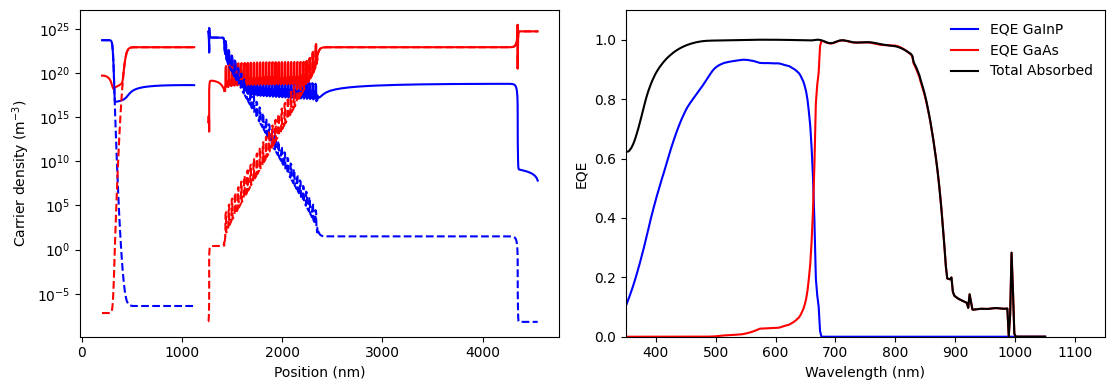

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.25, 4))
for j in my_solar_cell.junction_indices:
    zz = (
        my_solar_cell[j].short_circuit_data.Bandstructure["x"] + my_solar_cell[j].offset
    )
    n = my_solar_cell[j].short_circuit_data.Bandstructure["n"]
    p = my_solar_cell[j].short_circuit_data.Bandstructure["p"]
    ax1.semilogy(zz * 1e9, n, "b")
    ax1.semilogy(zz * 1e9, p, "r")
    zz = my_solar_cell[j].equilibrium_data.Bandstructure["x"] + my_solar_cell[j].offset
    n = my_solar_cell[j].equilibrium_data.Bandstructure["n"]
    p = my_solar_cell[j].equilibrium_data.Bandstructure["p"]
    ax1.semilogy(zz * 1e9, n, "b--")
    ax1.semilogy(zz * 1e9, p, "r--")
ax1.set_xlabel("Position (nm)")
ax1.set_ylabel("Carrier density (m$^{-3}$)")
plt.tight_layout()

labels = ["EQE GaInP", "EQE GaAs"]
colours = ["b", "r"]
for i, j in enumerate(my_solar_cell.junction_indices):
    ax2.plot(wl * 1e9, my_solar_cell[j].eqe(wl), colours[i], label=labels[i])
    
ax2.plot(wl * 1e9, my_solar_cell.absorbed, "k", label="Total Absorbed")
ax2.legend(loc="upper right", frameon=False)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("EQE")
ax2.set_ylim(0, 1.1)
ax2.set_xlim(350, 1150)
plt.tight_layout()

plt.show()

In [18]:
con

array([   1.        ,    1.46779927,    2.15443469,    3.16227766,
          4.64158883,    6.81292069,   10.        ,   14.67799268,
         21.5443469 ,   31.6227766 ,   46.41588834,   68.12920691,
        100.        ,  146.77992676,  215.443469  ,  316.22776602,
        464.15888336,  681.29206906, 1000.        ])

In [19]:
pmpp

[303.45988791354,
 450.15387860263496,
 667.5287701239625,
 989.614035300381,
 1466.7306497070485,
 2173.1835888198107,
 3219.0414033608604,
 4766.591337996023,
 7054.336424629964,
 10438.43782449603,
 15436.99761753204,
 22811.098951373577,
 33676.101477643424,
 49641.265858926505,
 73020.96144246729,
 106923.9163267523,
 154602.21395440414,
 183641.25105884418,
 184210.7511263931]

In [21]:
np.array(pmpp) / con / 10

array([30.34598879, 30.66862673, 30.98394086, 31.29434356, 31.59975393,
       31.8979728 , 32.19041403, 32.47440875, 32.74332918, 33.00923874,
       33.25800318, 33.48211433, 33.67610148, 33.82020073, 33.89332793,
       33.81231119, 33.30803729, 26.95484938, 18.42107511])

In [20]:
voc

[-2.3721797910886124,
 -2.393202069388773,
 -2.4143207210709265,
 -2.435236122840647,
 -2.45550914089154,
 -2.4758831719420087,
 -2.4964379872535747,
 -2.517153772643078,
 -2.5371597764167624,
 -2.5569244766247126,
 -2.5769990943921512,
 -2.5973003864812094,
 -2.617472850001343,
 -2.637486874618709,
 -2.6571103641066136,
 -2.676823842916043,
 -2.697096118705335,
 -2.7178826783141847,
 -2.7348723634708327]